# A mathematical approach to mob mentality 

>"A mob's always made up of people, no matter what. Mr. Cunningham was part of a mob last night, but he was still a man. Every mob in every little Southern town is always made up of people you know.”
> - Harper Lee, *To Kill a Mockingbird* (1960)

From lynch mobs to the Holocaust to the Rwandan genocide, many of the the worst atrocities in human history have  been commited by united groups of people who seeemed "ordinary" beforehand. It is hard to understand how this is possible- surely none of these populations was composed entirely of psycopaths, so how could they unanimously decide to support violence? I have struggled with this apparent paradox for years, as have many others. 

The resolution to the paradox may be in peer pressure, which can coerce people to act against their natural inclinations. In this notebook we will be building a mathematical model of peer pressure. Of course it will never perfectly replicate human decision-making, but hopefully it can shed some light on the mechanisms underlying mob mentality

## 1. Defining a model of human peer pressure

>“Human behavior is fragile and unpredictable and often at the mercy of the situation. Every individual still, of course, has a choice as to how to behave, it's just that for many people the situation is the key determinate in that choice.”
> - Lawrence Rees, *Auschwitz: A New History* (2005)

Our goal is to make a model of human behavior that incorporates the main elements of decision-making in the context of a potential mob action. Lawrence Rees, quoted above, has a valuable perspective for our purposes because he has spent his career documenting WWII-era atrocities. By his account, this model should include innate inclination, external factors, and some element of randomness. Then, assuming that people have the option of either supporting (+1) or opposing (-1) a movement, we can simply quantify those 3 factors, add them up, and use the sign to determine a person's behavior. 

The first question is how to quantify all of these factors. Tackling them one at a time
- We will define innate inclination as a normal RV. The mean and standard deviation will be included as parameters
- Each individuals' external situation is different, based on the people they interact with, so the first step here is to model the relationships of a full human society. There is a dense literature about how to accomplish this. Barabasi and Alberts' "Perferential Attachment Model" is known to be the most realistic interaction model, as seen [here](https://math.mit.edu/~apost/courses/18.204_2018/Lee_Bernick_paper.pdf), so we will use that to define peer relationships. 
    - Barabasi-Albert graphs are generated according to a degree parameter $m$. The average node will end up with $2*m$ connections. According to a [recent survey](https://72point.news/case-study-evite), the average American has 16 friends. Therefore an appropriate choice of $m$ to model a friendship network is 8
- To quantify the external situation for a single person, we will average the behavior of their peers. 
    - To be clear, this is average behavior, not average inclination. Nobody knows their neighbors' true inclinations 
- We will define the random factor to be normal RV with a mean of 0
    - The standard deviation will be included as a parameter, but mostly we will use 0.17 as a crude estimate. ([This study](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0184562) found that Facebook activity could predict the right/left divide with a 90% accuracy. Considering the average magnitude of innate inclination = 1, the average magnitude of neighbor behavior = 0.5, then the magnitude of the random factor should be about 0.17)

The final equation looks like this 

$B_i = sign(A_i + \frac{\sum \limits _{j \in N_i} B_{j}}{n_i} + \epsilon_i ) $

where $B_i$ is behavior (usually either -1 or -1), $A_i$ is innate inclination, $n_i$ is the number of neighbors a node has, $N_i$ is the set of those neighbors, and $\epsilon_i$ is a random factor

We have thus defined a process to update human behavior based on a peer pressure model. The second question is figuring out how to simulate a real society with this process. 

To do this, we will start with all behaviors set to neutral (0), then run the updating process on all individuals in the society multiple times. We will process each person at the same time for each iteration so that we can advantage of numpy vectorization and improve performance  

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import Symbol, diff, lambdify, solve, nsolve, exp
import datetime

from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import kurtosistest
from scipy.stats import skewtest
from scipy.stats import bernoulli
from sklearn.metrics import mean_absolute_error

In [2]:
#turning a list into an array is much faster with cython than it is with numpy

%load_ext cython

In [3]:
%%cython

cimport cython
import numpy as np

@cython.boundscheck(False)
cpdef to_array(list inp):
    cdef long[:] arr = np.zeros(len(inp), dtype=long)
    cdef Py_ssize_t idx
    for idx in range(len(inp)):
        arr[idx] = inp[idx]
    return np.asarray(arr)

In [4]:
def run_simulation(G
                   ,n_iterations
                   ,attitude_m
                   ,attitude_sd = 1
                   ,epsilon_sd = 0
):
    '''Simulates the defined peer pressure process over an existing network graph
    
    Args:
        G (networkx graph): Undirected graph defining peer relationships in a mock society
        n_iterations (int): Number of times to iterate through the behavior updating process
        attitude_m (float): Mean of attitude distribution
        attitude_sd (float): Standard deviation of attitude distribution
        epsilon_sd (float): Standard deviation of random factor

    Returns:
        Dictionary of form {epoch -> (mean resultant behavior)}
    '''
    length = len(G)
    attitudes = np.random.normal(loc = attitude_m
                                 ,scale = attitude_sd
                                 , size = length)

    for j in G.nodes:
        G.nodes[j]['behavior'] = 0

    node_list = list(G.nodes)
    
    res = {}
    
    rands = np.random.normal(scale = epsilon_sd,size = (n_iterations,length))
    
    neighbors = [[G.nodes[j] for j in G.neighbors(n)] for n in node_list]
    neighbor_node_list = [n for v,n in zip(neighbors,node_list) for x in v]
    labels = to_array(neighbor_node_list) #gets used later
    
    for i in range(n_iterations):
                
        neighbor_behaviors = [x['behavior'] for v in neighbors for x in v]
        average_neighbor_behaviors = clever_average(neighbor_behaviors, labels)
        
        new_behavior = np.sign(average_neighbor_behaviors + attitudes + rands[i])
        
        for j, v in zip(G.nodes, new_behavior):
            G.nodes[j]['behavior'] = v
                
        res[i] = np.mean([G.nodes[n]['behavior'] for n in G.nodes])
        
    return res

#this function is adapted from Vlad Feinberg, at https://vladfeinberg.com/2021/01/07/vectorizing-ragged-arrays.html
#the purpose is to do a more efficient 'jagged mean' via clever vectorization
def clever_average(Xz, labels):
    d = np.diff(labels, prepend=-1) # binary mask where labels change
    
    pos = np.flatnonzero(d) # indices where labels change
    pos = np.append(pos, len(Xz))
    
    Xz = np.concatenate((np.zeros_like(Xz[0:1]), Xz), axis=0)
    Xsums = np.cumsum(Xz, axis=0)

    # reduce by taking differences of accumulations exactly at the
    # endpoints for cluster indices, using pos array
    Xsums = np.diff(Xsums[pos], axis=0)
    counts = np.diff(pos)

    return Xsums / np.maximum(counts, 1)

## 1. Determing how large our "society" needs to be

We would like to understand the behavior of very large societies. However, simulating a large society would require a lot of computational power, so we would prefer to run the simulation on a small one if we can. Let's check if resultant behavior levels off at some point, allowing us to use a medium-size society as a proxy for larger ones.


In [6]:
def run_simulations(n_nodes
                     ,n_iterations
                     ,attitude_m
                     ,attitude_sd = 1
                     ,epsilon_sd = 0
                     ,n_trials = 5):
    '''Runs a simulation many times, and takes the average result
    
    Args:
        n_nodes (int): Number of nodes to use in BA graph
        n_iterations (int): Number of times to iterate through the behavior updating process
        attitude_m (float): Mean of attitude distribution
        attitude_sd (float): Standard Deviation of attitude distribution   
        epsilon_sd (float): Standard deviation of random factor
        n_trials (int): Number of times to run the simulation from scratch

    Returns:
        Dictionary of form {epoch -> (mean resultant behavior)}
    '''
    G = nx.generators.random_graphs.barabasi_albert_graph(n_nodes, 8)

    res = [run_simulation(G, n_iterations, attitude_m,attitude_sd,epsilon_sd) for i in range(n_trials)]
    
    return res


In [7]:
start = datetime.datetime.now()
ns = np.linspace(2,3.5,10)
all_res = [run_simulations(10**n, 20,0.1,1,0.17,100) for n in ns]
end = datetime.datetime.now()
print(end - start)

0:01:56.241236


In [8]:
y = [{r : np.mean([x[r] for x in res]) for r in res[0].keys()} for res in all_res]
result_df = pd.DataFrame.from_records(y)
result_df.index = [10**n for n in ns]
result_df.columns = ['Epoch: ' + str(col) for col in result_df.columns]

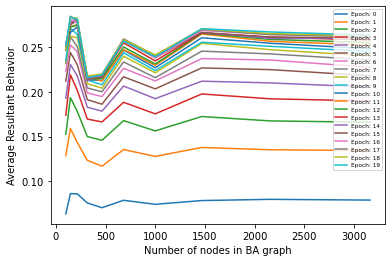

In [9]:
for col in result_df.columns:
    plt.plot(result_df.index,result_df[col], label = col) 
plt.xlabel('Number of nodes in BA graph')
plt.ylabel('Average Resultant Behavior')
plt.legend(fontsize = 'xx-small', loc = 'upper right')
plt.show()

Resultant behavior did not change much after 1500 nodes, so we will use 1500 for the rest of our investigations

## 2. Running our model with different distributions of attitudes

Now we will run our simulation many times with different values of $m$ to see how that effects behavior at the end of the process

In [30]:
def run_simulations(G
                     ,n_iterations
                     ,attitude_m
                     ,attitude_sd = 1
                     ,epsilon_sd = 0
                     ,n_trials = 5):
    '''Runs a simulation many times, and takes the average result
    
    Args:
        G (networkx graph): Undirected graph defining peer relationships in a mock society
        n_iterations (int): Number of times to iterate through the behavior updating process
        attitude_m (float): Mean of attitude distribution
        attitude_sd (float): Standard deviation of attitude distribution
        epsilon_sd (float): Standard deviation of random factor
        n_trials (int): Number of times to run the simulation from scratch

    Returns:
        Dictionary of form {epoch -> (mean resultant behavior)}
    '''
    res = [run_simulation(G, n_iterations, attitude_m,attitude_sd,epsilon_sd) for i in range(n_trials)]
    
    return res




In [31]:
#We will run with the same Barabasi-Albert graph every time, to reduce volatility
G = nx.generators.random_graphs.barabasi_albert_graph(1500, 8)

start = datetime.datetime.now()
ms = np.linspace(-1,1,30)
all_res_m = [run_simulations(G, 20,m, 1,0.17,60) for m in ms]
end = datetime.datetime.now()
print(end - start)

0:05:44.050784


### 2a. Resultant average behavior

In [32]:
y_m = [{r : np.mean([x[r] for x in res]) for r in res[0].keys()} for res in all_res_m]
result_df_m = pd.DataFrame.from_records(y_m)
result_df_m.index = ms
result_df_m.columns = ['Epoch: ' + str(col) for col in result_df_m.columns]

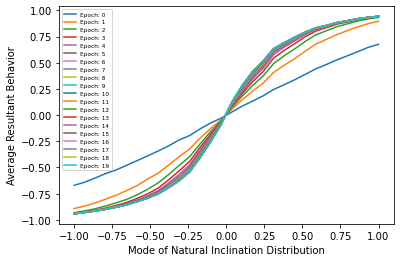

In [33]:
for col in result_df_m.columns:
    plt.plot(result_df_m.index,result_df_m[col], label = col) 
plt.xlabel('Mode of Natural Inclination Distribution')
plt.ylabel('Average Resultant Behavior')
plt.legend(fontsize = 'xx-small', loc = 'upper left')
plt.show()

There is a lot to unpack here. First, it is apparent that the initial conditions have a clear effect on the long-run outcome. When the mean initial attitude goes up, so does the average outcome behavior. 

For the first epoch, represented by the blue line in the middle, this relationship appears to be linear. However, it becomes increasingly nonlinear as the number of epochs increases. In particular, the slope around the center increases and the slopes further out approach zero. By the 20th epoch, a 0.5 difference in inclination mode around the middle results in a 0.9 difference in average outcome behavior. 

This suggests a 'critical mass' theory of social behavior. An attitude can be well-represented in a population, but if it does not quite reach the threshold of acceptability, it will be tamped down by social pressure. With a relatively small boost many in the middle are homogenized into support, creating stronger and stronger peer pressure until mob mentality takes over and only a minority of extreme oppponents are holding out. This phenomena could explain how widespread violent attitudes can seem to appear suddenly in a population. The actual attitudes of people do not need to flip overnight, they just needed to shift enough to reach a critical mass. 

Exactly how steep does the curve get in the middle? We can fit a curve to our data points, and compute a derivative directly. We will use a logistic and a polynomial equation, then calculate the derivative at 0 of the curve that fits best

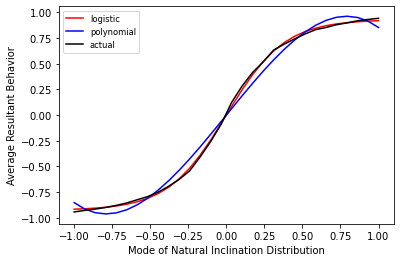

In [34]:
def logifunc(x,A,k, off):
    return A / (1 + np.exp(-k*(x)))+off

def polyfunc(x,a,b,c):
    return a*x**3 + b*x**2 + c*x**1

logi_popt, logi_pcov = curve_fit(logifunc, result_df_m.index, result_df_m['Epoch: 19'], p0=[9, 1, 0])

poly_popt, poly_pcov = curve_fit(polyfunc, result_df_m.index, result_df_m['Epoch: 19'], p0=[0,0,0])

plt.plot(result_df_m.index, logifunc(result_df_m.index,*logi_popt), color = 'red', label = 'logistic')
plt.plot(result_df_m.index, polyfunc(result_df_m.index,*poly_popt), color = 'blue', label = 'polynomial')
plt.plot(result_df_m.index, result_df_m['Epoch: 19'], color = 'black', label = 'actual')

plt.xlabel('Mode of Natural Inclination Distribution')
plt.ylabel('Average Resultant Behavior')
plt.legend(fontsize = 'small', loc = 'upper left')

plt.show()

The logistic curve fits the observed result very closely, with only a few degrees of freedom! The theoretical true curve may be a logistic, or something closely related

We will calculate the derivative of the logistic regression using sympy

In [37]:
x = Symbol('x')

A = logi_popt[0]
k = logi_popt[1]
off = logi_popt[2]

y = A / (1 + exp(-k*(x)))+off

dx = diff(y,x) 

ddx = lambdify(x, dx)     # this creates a function that you can call

print('at 0.0: ' + str(np.round(ddx(0),3)))
print('at 0.5: ' + str(np.round(ddx(0.5),3)))

at 0.0: 2.428
at 0.5: 0.615


The slope at $m=0$ is about 4 times higher than the slope at $m=0.5$. This shows how much more influential each person is when the society is near gridlock, vs. when it is already highly skewed in one direction

### 2a. Standard deviation of results

How does the volatility change with different input means?

In [38]:
y_std = [{r : np.std([x[r] for x in res]) for r in res[0].keys()} for res in all_res_m]
result_df_std = pd.DataFrame.from_records(y_std)
result_df_std.index = ms
result_df_std.columns = ['Epoch: ' + str(col) for col in result_df_std.columns]

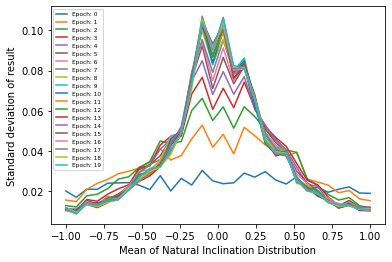

In [39]:
for col in result_df_std.columns:
    plt.plot(result_df_std.index,result_df_std[col], label = col) 
plt.xlabel('Mean of Natural Inclination Distribution')
plt.ylabel('Standard deviation of result')
plt.legend(fontsize = 'xx-small', loc = 'upper left')
plt.show()

There is definitely a peak- But maybe this peak is only due to the logistic nature of the result data? We can check if the peak still holds after transforming our data with a reverse link function

First step is to invert our fitted link function

In [40]:
def logifunc_inv(x,A,k, off):
    return np.log((x - off)/(A-x+off))/k

print(logifunc_inv(logifunc(0.5,*logi_popt),*logi_popt))
print(logifunc_inv(logifunc(-0.1,*logi_popt),*logi_popt))

0.4999999999999999
-0.09999999999999998


To avoid any infinite logs, we will use -1 as the offset and 2 as the scale parameter. That will make sure that there is a defined logit for every result

In [41]:
y_lstd = [{r : np.std([logifunc_inv(x[r],2,logi_popt[1],-1) for x in res]) for r in res[0].keys()} for res in all_res_m]
result_df_lstd = pd.DataFrame.from_records(y_lstd)
result_df_lstd.index = ms
result_df_lstd.columns = ['Epoch: ' + str(col) for col in result_df_lstd.columns]

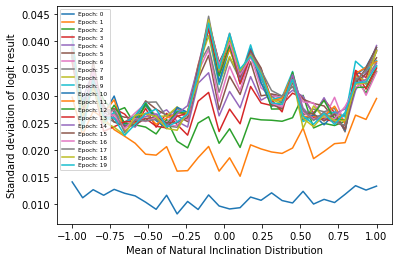

In [42]:
for col in result_df_lstd.columns:
    plt.plot(result_df_lstd.index,result_df_lstd[col], label = col) 
plt.xlabel('Mean of Natural Inclination Distribution')
plt.ylabel('Standard deviation of logit result')
plt.legend(fontsize = 'xx-small', loc = 'upper left')
plt.show()

Interestingly, it now seems like there are multiple peaks. The peak in the middle is the highest, but there are also auxiliary peaks to the side. Perhaps this happens because there is always some probability of an equilibrium going against the majority will, and that drives up the variance when the majority will is significantly biased.

# 3. Is this process converging?

Before moving forward, we should check to make sure that the process is converging. There are multiple ways we can think about this- to start, let's look at how much the result is changing after each epoch

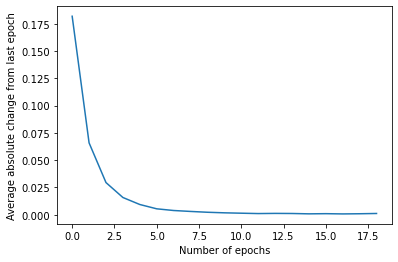

In [23]:
changes = [mean_absolute_error(result_df_m.iloc[:,i], result_df_m.iloc[:,i+1]) for i in range(result_df_m.shape[1] - 1)]
plt.plot(changes)
plt.xlabel('Number of epochs')
plt.ylabel('Average absolute change from last epoch')
plt.show()

It looks like the rate of change flattens out at around epoch 5 (the 6th epoch). 

We can also run a single experiment to the 100th epoch, to see if it is truly converging

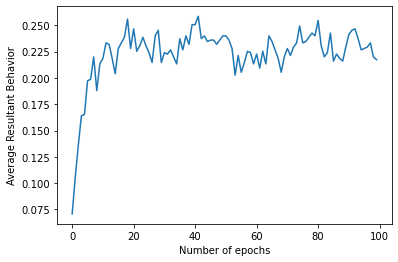

In [24]:
new_y = run_simulation(G, 100,0.1,1,0.17)
vals = [val for k, val in new_y.items()]

plt.plot(vals)
plt.xlabel('Number of epochs')
plt.ylabel('Average Resultant Behavior')
plt.show()

From this, it is apparent that the equilibrium is fully reached at around the 20th epoch. To be safe, lets use the 20th epoch moving forward. It should be a good estimate for the limit as the number of epochs goes to infinity

We should also check that the process converges to roughly the same number every time it is run with the same parameters. If the process converges to different numbers, then it is not really converging

In [25]:
many_y = run_simulations(G, 20,0,1,0.17,500)

In [28]:
print('skew: ' + str(skew([logifunc_inv(z[19],2,logi_popt[1],-1) for z in many_y])) + ' p value: ' + \
      str(skewtest([logifunc_inv(z[19],2,logi_popt[1],-1)for z in many_y])[1]))
print('kurtosis: ' + str(kurtosis([logifunc_inv(z[19],2,logi_popt[1],-1) for z in many_y])) + ' p value: ' + \
      str(kurtosistest([logifunc_inv(z[19],2,logi_popt[1],-1) for z in many_y])[1]))
px.histogram([z[19] for z in many_y], nbins = 20)


skew: 0.02724371362487949 p value: 0.8008415396496249
kurtosis: 0.2427943973791975 p value: 0.24073511858111551


Seems like the result is a normal distribution, or close to it.

Now Let's try something slightly different...

In [29]:
more_y_2 = run_simulations(G, 20,0,0.1,0.17,500)
px.histogram([z[19] for z in more_y_2], nbins = 20)

Woah, the distribution is suddenly bimodal! All we did was decrease the scale factor of the attitude distribution

Would we have seen this from our original experiment, if we had only run it for more epochs?

In [31]:
more_y_3 = run_simulations(G, 300,0,1,0.17,30)
px.histogram([z[299] for z in more_y_3], nbins = 20)

The answer seems to be no. So somewhere between 0.1 and 1, there must be some kind of threshold, below which the distribution becomes bimodal

A lot of experimentation could be done here. The last that I will do is using scale =0.7

In [35]:
more_y_4 = run_simulations(G, 20,0,0.7,0.17,500)
px.histogram([z[19] for z in more_y_4], nbins = 20)

The distribution has become extremely broad. On the way between broad normal and bimodal, perhaps there is a configuration that results in the uniform distribution? This is an interesting question but it would require a large number of simulations to find the right scale value


## 4. How does the random factor scale affect the result when m!=0?

Another aspect of this process that we will analyze is the role of the random factor's scale on ameliorating/bolstering consensus. Setting the mode attitude to 0.3 arbitrarily, we will see how the random factor affects resultant behavior. 

In [37]:
sds = np.linspace(0,2,200)

start = datetime.datetime.now()
all_res_sd = [run_simulations(G, 20,0.3,1,sd,10) for sd in sds]
end = datetime.datetime.now()
print(end - start)

y_sd = [{r : np.mean([x[r] for x in res]) for r in res[0].keys()} for res in all_res_sd]

result_df_sd = pd.DataFrame.from_records(y_sd)
result_df_sd.index = sds
result_df_sd.columns = ['Epoch: ' + str(col) for col in result_df_sd.columns]

0:06:46.018410


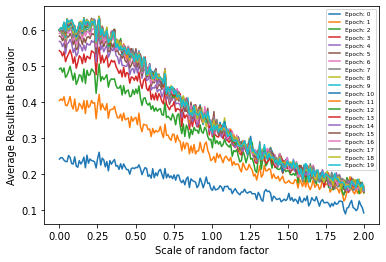

In [38]:
for col in result_df_sd.columns:
    plt.plot(result_df_sd.index,result_df_sd[col], label = col) 
plt.xlabel('Scale of random factor')
plt.ylabel('Average Resultant Behavior')
plt.legend(fontsize = 'xx-small', loc = 'upper right')
plt.show()

According to this graph, the resultant behavior goes from down as the scale increases. This makes sense. As the random factor gets scaled up, initial attitudes matter less and randomness begins to dominate, pushing resultant behavior towards a neutral zero.

A more curious result is that while the first derivative is consistently negative, the second derivate flips from negative to positive at approximately 0.8. That is, increases in randomness hardly budge the result when randomness is small. As randomness increases, opposition gets a foothold and makes a dent on the majority behavior. Then as randomness increases even more, it stops making a difference as the attitude approaches its asymptote.

To get an estimate of where the second derivative flips, we will again try a logistic and polynomial expressions. This is clearly not a usual logistic curve, so we will use the general logistic equation, which allows for more flexibility with more degrees of freedom. To make the comparison fair we will allow the polynomial an equivalent 6 degrees of freedom

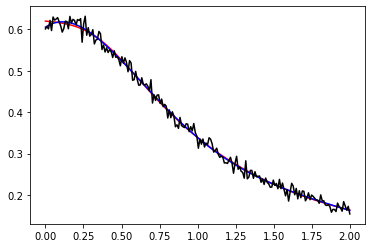

In [39]:
def gen_logifunc(x,A,K,C,Q,B,v):
    return A + ((K-A)/ (C + Q*np.exp(-B*(x)))**(1/v))

def big_polyfunc(x,a,b,c,d,e,f):
    return a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f

logi_popt, logi_pcov = curve_fit(gen_logifunc, result_df_sd.index, result_df_sd['Epoch: 19'], p0=[0, 1, 1,1,1,1])

poly_popt, poly_pcov = curve_fit(big_polyfunc, result_df_sd.index, result_df_sd['Epoch: 19'], p0=[0,0,0,0,0,0])

plt.plot(result_df_sd.index, gen_logifunc(result_df_sd.index,*logi_popt), color = 'red')
plt.plot(result_df_sd.index, big_polyfunc(result_df_sd.index,*poly_popt), color = 'blue')
plt.plot(result_df_sd.index, result_df_sd['Epoch: 19'], color = 'black')

In [40]:
gen_logifunc(50,*logi_popt)

0.08729294373793994

The fitted logistic function appears to represent the empirical result well. However, there is a discrepancy between the fitted function and the expected behavior of the actual process. The function predicts that the curve will reach a y-asymptote around 0.09, never getting closer to 0 no matter how high the x-variable goes. This contradicts with our understanding of the actual process, which we expect to go to 0 with arbitrarily high random factors (at a certain point, the random factor will be so large that the probability of other factors effecting the result will be infinitessimally small)

However, we can still get an estimate of where the second derivative flips with sympy

In [42]:

x = Symbol('x')

A = logi_popt[0]
K = logi_popt[1]
C = logi_popt[2]
Q = logi_popt[3]
B = logi_popt[4]
v = logi_popt[5]

y = A + ((K-A)/ (C + Q*exp(-B*(x)))**(1/v))

d_2 = diff(y, x, x)

nsolve(d_2, (0,1), solver = 'bisect') #the normal solver doesn't work here: sympy doesn't know how to solve it explicitly

0.596086637744425

Interesting! That is approximately 0.6, but off slightly. I wonder what the exact inflection point would be if we ran over multiple Barabasi-Albert graphs and took the expected value at each point. Calculating it would take either a lot of computation or a lot of math, which I will leave for another day

## 5. The role of apathy

>"We must always take sides. Neutrality helps the oppressor, never the victim. Silence encourages the tormentor, never the tormented."
> - Elie Wiesel, Nobel Prize acceptance speech (1986)

Elie Wiesel and many others have condemned the silence of bystanders during the Holocaust. According to them, apathy was a key factor in allowing the Holocaust to happen. Can we include that in our model?

A simple way to model this is to use an apathy switch, which can be either 0 or 1. When the apathy switch is 1 the node's behavior will be 0. To seed these apathies we will use bernoulli random trials with parameter p, where p will be an input to the simulation function.



In [9]:
def run_simulation_with_apathy(G
                               ,n_iterations
                               ,attitude_m
                               ,attitude_sd
                               ,fraction_a
                               ,a_bilateral
                               ,epsilon_sd = 0):
    
    '''Simulates the defined peer pressure process over an existing network graph, with unidirectional apathy
    
    Args:
        G (networkx graph): Undirected graph defining peer relationships in a mock society
        n_iterations (int): Number of times to iterate through the behavior updating process
        attitude_m (float): Mean of attitude distribution
        attitude_sd (float): Scale of attitude distribution
        fraction_a (float): Bernoulli parameter for setting apathy switch to 0 or 1 for each person
        a_bilateral (bool): switch for bilateral apathy, as opposed to unilateral
        epsilon_sd (float): standard deviation of random factor

    Returns:
        Dictionary of form {epoch -> (mean resultant behavior)}
    '''
    length = len(G)
    attitudes = np.random.normal(loc = attitude_m
                                 ,scale = attitude_sd
                                 , size = length)
    for j in G.nodes:
        G.nodes[j]['behavior'] = 0

    #before here 
    apathies = bernoulli.rvs(fraction_a, size = length)
    apathy_dict = {i : apathies[i] for i in range(len(apathies))}
    nx.set_node_attributes(G, apathy_dict, "apathy")
        
    node_list = list(G.nodes)
    
    res = {}
    
    rands = np.random.normal(scale = epsilon_sd,size = (n_iterations,length))
    
    neighbors = [[G.nodes[j] for j in G.neighbors(n)] for n in node_list]
    neighbor_node_list = [n for v,n in zip(neighbors,node_list) for x in v]
    labels = to_array(neighbor_node_list) #gets used later
    
    for i in range(n_iterations):
                
        if a_bilateral:
            neighbor_behaviors = [x['behavior'] if not x['apathy'] else 0 \
                      for v in neighbors for x in v ]
        else:
            neighbor_behaviors = [x['behavior'] if not (x['apathy'] and not x['behavior'] ==1) else 0 \
                                  for v in neighbors for x in v ]

        average_neighbor_behaviors = clever_average(neighbor_behaviors, labels)
        
        new_behavior = np.sign(average_neighbor_behaviors + attitudes + rands[i])
        
        for j, v in zip(G.nodes, new_behavior):
            G.nodes[j]['behavior'] = v
                
        res[i] = np.mean([G.nodes[n]['behavior'] for n in G.nodes])
        
    return res

In [10]:
def run_simulations_with_apathy(G
                                ,n_iterations
                                ,attitude_m
                                ,attitude_sd
                                ,fraction_a
                                ,a_bilateral = False
                                ,epsilon_sd = 0
                                , n_trials = 5):
    '''Runs a simulation with apathy many times, and takes the average result
    
    Args:
        G (networkx graph): Undirected graph defining peer relationships in a mock society
        n_iterations (int): Number of times to iterate through the behavior updating process
        attitude_m (float): Mean of attitude distribution
        attitude_sd (float): Mean of attitude distribution
        fraction_a (float): Bernoulli parameter for setting apathy switch to 0 or 1 for each person
        a_bilateral (bool): switch for bilateral apathy, as opposed to unilateral
        epsilon_sd (float): standard deviation of random factor.
        n_trials (int): Number of times to run the simulation from scratch

    Returns:
        Dictionary of form {epoch -> (mean resultant behavior)}
    '''
    res = [run_simulation_with_apathy(G, n_iterations, attitude_m,attitude_sd,fraction_a,a_bilateral,epsilon_sd) for i in range(n_trials)]
    
    return res



### 5a. Unilateral apathy

First, we will apply apathy only to the opposition side. That is, an apathetic person will withdraw from the peer behavior process if and only if they are in opposition. This could model situations where speaking out against something has a cost and speaking in support does not, like when the government can punish those who speak out against it.

We will run a number of experiments with this apathy lever, varying the amount of apathy and seeing what happens. To isolate the effect of unilateral apathy, we will set the mode of the natural inclinations to zero.

In [18]:
G = nx.generators.random_graphs.barabasi_albert_graph(1500, 8)

start = datetime.datetime.now()
ps = np.linspace(0,1,15) 
all_res_p = [run_simulations_with_apathy(G, 20,0,1,p,False,0.17,100) for p in ps]
end = datetime.datetime.now()
print(end - start)

0:07:44.772469


In [19]:
y_p = [{r : np.mean([x[r] for x in res]) for r in res[0].keys()} for res in all_res_p]

result_df_p = pd.DataFrame.from_records(y_p)
result_df_p.index = ps
result_df_p.columns = ['Epoch: ' + str(col) for col in result_df_p.columns]

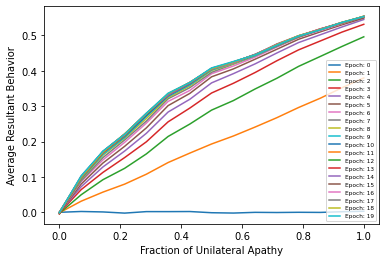

In [20]:
for col in result_df_p.columns:
    plt.plot(result_df_p.index,result_df_p[col], label = col) 
plt.xlabel('Fraction of Unilateral Apathy')
plt.ylabel('Average Resultant Behavior')
plt.legend(fontsize = 'xx-small', loc = 'lower right')
plt.show()

It is clear that unilateral apathy has a real effect on an otherwise evenly split population. This suggests that another way for mob mentality to take over is for opponents to be less interested than supporters, allowing the supporters to dominate the public narrative


### 5b. Bilateral apathy

Another way to look at apathy is to consider bilateral apathy, which applies equally to both sides. If we kept m = 0 the simulation would be entirely symmetrical and therefore the resultant expectant behavior would be 0 no matter what. To make things interesting, we will use a slightly skewed distribution from the start, and see how apathy interacts with it

In [23]:
start = datetime.datetime.now()
ps = np.linspace(0,1,15) 
all_res_pb = [run_simulations_with_apathy(G, 20,0.1,1,p,True,0.17,100) for p in ps]
end = datetime.datetime.now()
print(end - start)

0:05:46.276837


In [24]:
y_pb = [{r : np.mean([x[r] for x in res]) for r in res[0].keys()} for res in all_res_pb]
result_df_pb = pd.DataFrame.from_records(y_pb)
result_df_pb.index = ps
result_df_pb.columns = ['Epoch: ' + str(col) for col in result_df_pb.columns]

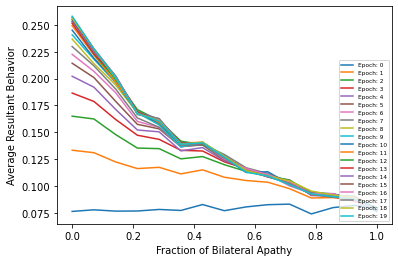

In [25]:
for col in result_df_pb.columns:
    plt.plot(result_df_pb.index,result_df_pb[col], label = col) 
plt.xlabel('Fraction of Bilateral Apathy')
plt.ylabel('Average Resultant Behavior')
plt.legend(fontsize = 'xx-small', loc = 'lower right')
plt.show()

The result shows that higher bilateral apathy actually tamps down on 'critical mass' effects. This suggests that societies where people are politically engaged are more susceptible to radical homogenization than those where people are not engaged

## 6. Conclusion 

In this notebook we looked at a simple model for peer pressure. It showed that a small imbalance in a population's attitudes can transform societal behavior from strong public opposition to strong public support. This could explain how entire groups of people can seem to get much more violent in a small amount of time. This also warns us that dangerous attitudes might be lying under the surface of any society, waiting for the right circumstances to catapult them into the mainstream. 

I believe that there is a huge amount of work that could be done extending this kind of model
- Modeling society with different kinds of graphs, besides Barabasi-Albert
- Seeding attitudes with different random processes
- Adding more sophisticated mechanisms of behavior, ideally informed by psychology research